# Interest-based Post Recommender (Hybrid: Content + CF)

_A clean, Colab-style notebook you can run end-to-end._

In [1]:
# %% [markdown]
# ## Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix, vstack as sp_vstack
import warnings
warnings.filterwarnings("ignore")

In [2]:
# %% [markdown]
# ## Load Data
# Adjust the paths below if running outside this environment.
USERS_PATH = "Users.csv"
POSTS_PATH = "Posts.csv"
ENG_PATH   = "Engagements.csv"

users = pd.read_csv(USERS_PATH)
posts = pd.read_csv(POSTS_PATH)
eng   = pd.read_csv(ENG_PATH)

users.head(), posts.head(), eng.head()


(  user_id  age gender          top_3_interests  past_engagement_score
 0      U1   24      F      sports, art, gaming                   0.61
 1      U2   32      F    travel, food, fashion                   0.93
 2      U3   28  Other  sports, travel, fashion                   0.40
 3      U4   25      M     fashion, music, tech                   0.53
 4      U5   24      M   fashion, food, fitness                   0.80,
   post_id creator_id content_type            tags
 0      P1        U44        video    sports, food
 1      P2        U26        video   music, travel
 2      P3        U32         text  sports, travel
 3      P4         U6        image   music, gaming
 4      P5        U32        image   food, fashion,
   user_id post_id  engagement
 0      U1     P52           1
 1      U1     P44           0
 2      U1      P1           1
 3      U1      P4           1
 4      U1     P65           0)

Users: (50, 5) ['user_id', 'age', 'gender', 'top_3_interests', 'past_engagement_score']
Posts: (100, 4) ['post_id', 'creator_id', 'content_type', 'tags']
Engagements: (1000, 3) ['user_id', 'post_id', 'engagement']

Unique users: 50
Unique posts: 100
Unique creators: 43


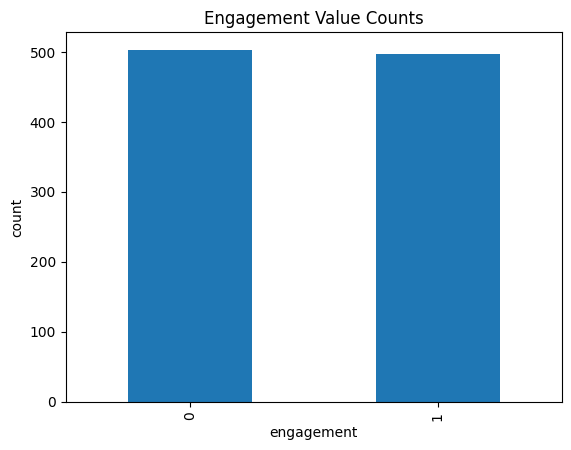

In [3]:
# %% [markdown]
# ## Quick EDA
print("Users:", users.shape, list(users.columns))
print("Posts:", posts.shape, list(posts.columns))
print("Engagements:", eng.shape, list(eng.columns))

# Basic distributions
print("\nUnique users:", users['user_id'].nunique())
print("Unique posts:", posts['post_id'].nunique())
print("Unique creators:", posts['creator_id'].nunique())

# Plot engagement distribution (if numeric/binary)
if 'engagement' in eng.columns:
    eng['engagement'].value_counts(dropna=False).sort_index().plot(kind="bar")
    plt.title("Engagement Value Counts")
    plt.xlabel("engagement")
    plt.ylabel("count")
    plt.show()


In [4]:
# %% [markdown]
# ## Preprocess: Split Interests, Normalize Post Text

# Split and clean interests
if "top_3_interests" in users.columns:
    split_cols = users["top_3_interests"].fillna("").astype(str).str.split(",", expand=True)
    # keep up to 3 columns
    split_cols = split_cols.iloc[:, :3] if split_cols.shape[1] >= 3 else split_cols.reindex(columns=[0,1,2])
    split_cols = split_cols.rename(columns={0:"interest_1",1:"interest_2",2:"interest_3"})
    for c in ["interest_1","interest_2","interest_3"]:
        if c in split_cols.columns:
            split_cols[c] = split_cols[c].fillna("").astype(str).str.strip()
        else:
            split_cols[c] = ""
    users = pd.concat([users, split_cols], axis=1)

# Normalize posts text from content_type + tags
posts["tags"] = posts["tags"].fillna("").astype(str)
posts["content_type"] = posts["content_type"].fillna("").astype(str)
posts["post_text"] = posts["content_type"].str.replace(r"[_\-]", " ", regex=True) + " " + posts["tags"].str.replace(",", " ")
posts[["post_id","post_text"]].head()


,post_id,post_text
0,P1,video sports food
1,P2,video music travel
2,P3,text sports travel
3,P4,image music gaming
4,P5,image food fashion


In [5]:
# %% [markdown]
# ## TF-IDF for Content-Based Similarity
tfidf = TfidfVectorizer(lowercase=True, token_pattern=r"(?u)\b\w+\b", ngram_range=(1,2), min_df=1)
post_tfidf = tfidf.fit_transform(posts["post_text"])
post_tfidf.shape


(100, 90)

In [6]:
# %% [markdown]
# ## Build User Content Profiles (Interests + History)

def interests_to_vector(row):
    # Join up to three interests
    interests = " ".join([str(row.get("interest_1","")), str(row.get("interest_2","")), str(row.get("interest_3",""))]).strip()
    return tfidf.transform([interests])

# Interest vectors
user_interest_vecs = [interests_to_vector(row) for _, row in users.iterrows()]
user_interest_mat = sp_vstack(user_interest_vecs) if len(user_interest_vecs) else csr_matrix((0, post_tfidf.shape[1]))

# Map IDs to indices
user_ids = users["user_id"].astype(str).tolist()
post_ids = posts["post_id"].astype(str).tolist()
u_index = {u:i for i,u in enumerate(user_ids)}
p_index = {p:i for i,p in enumerate(post_ids)}

# Ensure types in engagements
eng = eng.copy()
eng["user_id"] = eng["user_id"].astype(str)
eng["post_id"] = eng["post_id"].astype(str)

# Keep only known users/posts in engagements
eng = eng[eng["user_id"].isin(u_index) & eng["post_id"].isin(p_index)]

# Build a history-weighted user profile from engaged posts
num_users = len(u_index)
user_history_mat = csr_matrix((num_users, post_tfidf.shape[1]))

if eng.shape[0] > 0:
    grouped = eng.groupby("user_id")
    rows, mats = [], []
    for uid, grp in grouped:
        ridx = u_index[uid]
        pidx = grp["post_id"].map(p_index).values
        weights = grp["engagement"].astype(float).values
        wsum = weights.sum()
        if wsum <= 0 or len(pidx) == 0:
            continue
        # Weighted average of post vectors
        user_vec = (post_tfidf[pidx].multiply(weights[:, None])).sum(axis=0) / wsum
        rows.append(ridx)
        mats.append(csr_matrix(user_vec))
    if mats:
        stacked = sp_vstack(mats)
        user_history_mat = csr_matrix(user_history_mat, copy=True)
        user_history_mat[rows, :] = stacked

alpha = 0.6  # interests vs history weight
user_content_vec = (alpha * user_interest_mat) + ((1 - alpha) * user_history_mat)
user_content_vec.shape


(50, 90)

In [7]:
# %% [markdown]
# ## Collaborative Filtering via SVD

num_items = len(p_index)
row_idx = eng["user_id"].map(u_index).values
col_idx = eng["post_id"].map(p_index).values
data_vals = eng["engagement"].astype(float).values

ui = csr_matrix((data_vals, (row_idx, col_idx)), shape=(num_users, num_items))

k = min(20, min(num_users, num_items) - 1) if min(num_users, num_items) > 2 else 2
svd = TruncatedSVD(n_components=k, random_state=42)
user_f = svd.fit_transform(ui)   # U * Sigma
item_f = svd.components_.T       # V
cf_scores = np.dot(user_f, item_f.T)  # (num_users x num_items)
cf_scores.shape


(50, 100)

In [8]:
# %% [markdown]
# ## Content-Based Scores (Cosine Similarity)
content_scores = cosine_similarity(user_content_vec, post_tfidf)  # (num_users x num_items)
content_scores.shape


(50, 100)

In [9]:
# %% [markdown]
# ## Hybrid Scores & Top-3 Recommendations
lambda_hybrid = 0.5  # blend CF and content
hybrid_scores = lambda_hybrid * content_scores + (1 - lambda_hybrid) * cf_scores

# Exclude already positively engaged posts
already = eng[eng["engagement"] > 0].groupby("user_id")["post_id"].apply(set).to_dict()

top_k = 3
recs = []
for uid in user_ids:
    uidx = u_index[uid]
    scores = hybrid_scores[uidx]
    exclude = already.get(uid, set())
    order = np.argsort(-scores)  # descending
    picks, pick_scores = [], []
    for j in order:
        pid = post_ids[j]
        if pid in exclude:
            continue
        picks.append(pid)
        pick_scores.append(float(scores[j]))
        if len(picks) == top_k:
            break
    while len(picks) < top_k:
        picks.append(None)
        pick_scores.append(None)
    recs.append({
        "user_id": uid,
        "rec_1": picks[0], "score_1": pick_scores[0],
        "rec_2": picks[1], "score_2": pick_scores[1],
        "rec_3": picks[2], "score_3": pick_scores[2],
    })

recs_df = pd.DataFrame(recs)
recs_df.head()


,user_id,rec_1,score_1,rec_2,score_2,rec_3,score_3
0,U1,P78,0.396052,P22,0.377257,P65,0.308732
1,U2,P80,0.307296,P5,0.280657,P92,0.228584
2,U3,P39,0.314960,P3,0.279060,P5,0.236909
3,U4,P53,0.517900,P89,0.315763,P96,0.275659
4,U5,P26,0.392569,P7,0.328588,P69,0.326750


In [10]:
# %% [markdown]
# ## Quick (Simulated) Validation: Hit-Rate@3
np.random.seed(42)
pos = eng[eng["engagement"] > 0].copy()
if len(pos) > 0:
    pos["rand"] = np.random.rand(len(pos))
    holdout = pos[pos["rand"] < 0.1]
    holdout_map = holdout.groupby("user_id")["post_id"].apply(set).to_dict()

    hits, total = 0, 0
    for uid, items in holdout_map.items():
        rec_row = recs_df[recs_df["user_id"] == uid]
        if rec_row.empty:
            continue
        recs_set = set(rec_row[["rec_1","rec_2","rec_3"]].values.flatten().tolist())
        recs_set.discard(None)
        total += 1
        if len(recs_set & items) > 0:
            hits += 1

    hit_rate_at3 = (hits / total) if total > 0 else np.nan
else:
    hit_rate_at3 = np.nan

print("Hit-Rate@3:", hit_rate_at3)


Hit-Rate@3: 0.0


In [13]:
# %% [markdown]
# ## Save Outputs (Recommendations CSV + Short Report)
recs_path = "recommendations.csv"
recs_df.to_csv(recs_path, index=False)
print("Saved:", recs_path)

report = f"""# Hybrid Recommender (Content + CF)

**Data**: Users (n={len(users)}), Posts (n={len(posts)}), Engagements (n={len(eng)}).

## Method
1. **Content-based**:
   - TF-IDF over `content_type + tags` for each post.
   - User profile = 0.6 × TF-IDF(interests) + 0.4 × TF-IDF(history-weighted).
   - Score = cosine similarity between user profile and post vectors.

2. **Collaborative Filtering**:
   - User–Item matrix from `engagement`.
   - Low-rank factors via TruncatedSVD (k={int(min(20, min(len(users), len(posts)) - 1)) if min(len(users), len(posts)) > 2 else 2}).
   - Score = reconstructed dot product between user and item factors.

3. **Hybrid**:
   - Final score = 0.5 × Content + 0.5 × CF.
   - Exclude posts already positively engaged by the user.
   - Return Top-3 per user.

## Quick Validation (simulated)
- 10% random holdout of positive interactions per user (no timestamps available).
- **Hit-Rate@3** = {hit_rate_at3:.3f} (nan if no positives/holdouts).

## Notes & Extensions
- If timestamps exist, do a **time-based split** to avoid leakage.
- Tune weights `alpha` (interests vs history) and `lambda` (content vs CF) by validation.
- Replace TF-IDF with **SentenceTransformers** if post text is richer.
- Replace SVD with **implicit ALS** or **Neural CF** for stronger collaborative signal.
- Add **diversity** constraints (MMR) and **freshness** boosts for production.
"""

report_path = "report.md"
with open(report_path, "w") as f:
    f.write(report)
print("Saved:", report_path)


Saved: recommendations.csv
Saved: report.md


In [ ]:
# %% [markdown]
# ## Next Steps
# - Use time-based split if timestamps exist to avoid leakage.
# - Hyperparameter tuning for `alpha` and `lambda_hybrid`.
# - Consider implicit ALS (e.g., `implicit` library) or Neural CF for stronger CF.
# - Use SentenceTransformers for richer text embeddings if post descriptions are long.
# - Add re-ranking for diversity and freshness.
